In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6544428027217687695
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22729785344
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2892028405999639966
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
def image_generator(files, batch_size =10 , sz = (256, 256)):
  
    while True: 
    
        # extract a random batch 
        batch = np.random.choice(files, size = batch_size)    
    
        # variables for collecting batches of inputs and outputs 
        batch_x = []
        batch_y = []
    
    
        for f in batch:
        
            # get the masks. Note that masks are png files 
            mask = Image.open(f[-9::-1][::-1]+'_fg.png')
            mask = np.array(mask.resize(sz))


            # preprocess the mask 
            mask[mask >= 2] = 0 
            mask[mask != 0 ] = 1
        
            batch_y.append(mask)

            #preprocess the raw images 
            raw = Image.open(f)
            raw = raw.resize(sz)
            raw = np.array(raw)

            # check the number of channels because some of the images are RGBA or GRAY
            if len(raw.shape) == 2:
                raw = np.stack((raw,)*3, axis=-1)

            else:
                raw = raw[:,:,0:3]

            batch_x.append(raw)

        # preprocess a batch of images and masks 
        batch_x = np.array(batch_x) / 255.
        batch_y = np.array(batch_y)
        batch_y = np.expand_dims(batch_y, 3)

        yield (batch_x, batch_y)

In [4]:
all_files=[]

for i in os.listdir('E:/CVPPP2017_LSC_training/images/A1'):
    if i[-5:]=='b.png':
        all_files.append('E:/CVPPP2017_LSC_training/images/A1/'+i)  
        
for i in os.listdir('E:/CVPPP2017_LSC_training/images/A2'):
    if i[-5:]=='b.png':
        all_files.append('E:/CVPPP2017_LSC_training/images/A2/'+i)   
        
for i in os.listdir('E:/CVPPP2017_LSC_training/images/A3'):
    if i[-5:]=='b.png':
        all_files.append('E:/CVPPP2017_LSC_training/images/A3/'+i)   
        
for i in os.listdir('E:/CVPPP2017_LSC_training/images/A4'):
    if i[-5:]=='b.png':
        all_files.append('E:/CVPPP2017_LSC_training/images/A4/'+i)

In [13]:
all_files

['E:/CVPPP2017_LSC_training/images/A4/plant0065_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0084_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0378_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0448_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A1/plant148_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0206_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A1/plant147_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0565_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0177_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A1/plant120_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A3/plant007_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0111_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0381_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0160_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0051_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A2/plant023_rgb.png',
 'E:/CVPPP2017_LSC_training/images/A4/plant0539_rgb.png',
 'E:/CVPPP2017_LSC_

In [5]:
batch_size = 10
shuffle(all_files)
split = int(0.9 * len(all_files))
#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

x, y = next(train_generator)

In [18]:
print(x.shape)
print(y.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [11]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    
    return iou

In [26]:
def unet(sz = (256, 256, 3)):
    x = Input(sz)
    inputs = x
  
    # down sampling 
    f = 8
    layers = []
  
    for i in range(0, 6):
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        layers.append(x)
        x = MaxPooling2D() (x)
        f = f*2
    ff2 = 64 
  
    # bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='tanh', padding='same') (x)
    x = Conv2D(f, 3, activation='tanh', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
  
    # upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        x = Conv2D(f, 3, activation='tanh', padding='same') (x)
        x = Conv2D(f, 3, activation='tanh', padding='same') (x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 
    
  
    # classification 
    x = Conv2D(f, 3, activation='tanh', padding='same') (x)
    x = Conv2D(f, 3, activation='tanh', padding='same') (x)
    outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
    # model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
    return model

In [27]:
model = unet()

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 8)  224         ['input_4[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_29[0][0]']              
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 8)  0          ['conv2d_30[0][0]']        

In [30]:
train_steps = len(train_files) // batch_size
test_steps = len(test_files) // batch_size

model.fit_generator(train_generator, epochs = 100, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = 10, verbose = 1)

model.save_weights('E:/UNET_LeafSeg/weights.h5')

C:\Users\Moon\Anaconda3\envs\iml\lib\site-packages\ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
72/72 [==============================] - 18s 254ms/step - loss: 0.0244 - mean_iou: 0.6473 - val_loss: 0.1184 - val_mean_iou: 0.2271
Epoch 2/100
72/72 [==============================] - 15s 215ms/step - loss: 0.0247 - mean_iou: 0.6533 - val_loss: 0.0113 - val_mean_iou: 0.8060
Epoch 3/100
72/72 [==============================] - 14s 191ms/step - loss: 0.0171 - mean_iou: 0.7834 - val_loss: 0.0155 - val_mean_iou: 0.8560
Epoch 4/100
72/72 [==============================] - 14s 195ms/step - loss: 0.0139 - mean_iou: 0.7174 - val_loss: 0.0094 - val_mean_iou: 0.5690
Epoch 5/100
72/72 [==============================] - 14s 191ms/step - loss: 0.0187 - mean_iou: 0.7367 - val_loss: 0.0107 - val_mean_iou: 0.9048
Epoch 6/100
72/72 [==============================] - 13s 180ms/step - loss: 0.0141 - mean_iou: 0.7965 - val_loss: 0.0096 - val_mean_iou: 0.8260
Epoch 7/100
72/72 [==============================] - 13s 183ms/step - loss: 0.0136 - mean_iou: 0.7521 - val_loss: 0.0095 - val_mean_iou:

In [31]:
inference_model = unet()

inference_model.load_weights('E:/UNET_LeafSeg/weights.h5')

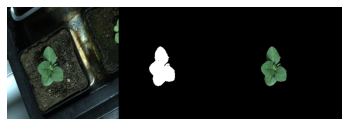

In [33]:
img = 'E:/CVPPP2017_LSC_training/images/A3/plant005_rgb.png'

raw = Image.open(img)
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()